In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import date
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import kneighbors_graph,KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")
plt.style.use(['dark_background'])
np.random.seed(0)

### Read Data

In [3]:
rawdata = pd.read_csv("rawratios.csv")
rawdata.drop(["adate","public_date"],inplace=True,axis=1)
rawdata["Qyear"]=rawdata["qdate"].map(lambda x: int(str(x)[:4]))
ratdesc = pd.read_csv("ratdesc.csv")
ratdesc.set_index("Variable Name",inplace=True)
compdesc = pd.read_csv("compnames.csv")
compdesc.columns=["permno","compname"]
compdesc.set_index("permno",inplace=True)

### Modify Data

In [4]:
basedata = rawdata[(rawdata["Qyear"]>=2014) & (rawdata["Qyear"]<=2016)]
basedata = basedata.groupby(["permno"]).mean()
basedata.drop(["qdate","Qyear"],axis=1, inplace = True)
basedata = basedata.fillna(basedata.mean())

In [5]:
basedata.head(3)

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing
permno,,,,,,,,,,,,,,,,,,,,,
10026,34.227611,0.310750,13.316333,28.899333,29.099944,29.129639,29.129639,2.184139,19.699917,0.342750,...,10.730083,1.650583,1.653083,4.767417,0.001,0.004167,0.0,0.047500,3.291417,3.738944
10032,17.910389,0.602500,10.061917,15.565583,15.980111,17.036444,17.036444,0.574611,-9.010389,0.000000,...,5.995667,2.366833,3.092583,3.505917,0.000,0.000000,0.0,0.019750,1.715639,2.357121
10044,19.963917,0.282083,10.391667,16.419306,17.126806,17.904083,17.904083,1.731472,10.525972,0.671667,...,14.221417,1.639500,2.128667,4.686083,0.000,0.009667,0.0,0.081333,3.538833,0.997222


In [6]:
sec_forrec = rawdata[rawdata["Qyear"]==2017].permno.unique()
sec_inbasedata = np.array(basedata.index.unique())
sec_testlist=[]
for item in sec_forrec:
    if item not in sec_inbasedata:
        sec_testlist.append(item)
print("Number of items for testing:",len(sec_testlist))
print("Number of items for clustering:",basedata.shape[0])


Number of items for testing: 140
Number of items for clustering: 1831


### Scaler

In [7]:
scaler = MinMaxScaler((0,1))
basedatasc = scaler.fit_transform(basedata)

In [8]:
basedatasc.shape

(1831, 68)

### PCA & TNSE

PCA

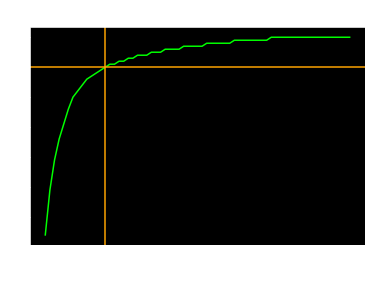

14 variables is sufficient to explain 0.9 of data.


In [9]:
varper=0.90
pcaexpvar =[]
pcano =[]
for i in range(1,basedatasc.shape[1]):
    pca = PCA(n_components=i)
    pca.fit(basedatasc)  
    pcaexpvar.append(round(sum(pca.explained_variance_ratio_),2))
    pcano.append(i)
    
    
plt.plot(pcano,pcaexpvar,c="#00FF00")
plt.title("PCA Explained Variance Ratio",fontsize=20)
plt.xlabel("Number of Variables")
plt.axhline(0.90,c="orange")
plt.axvline(14,c="orange")
plt.savefig("PCA.png",quality=100)
plt.show()

print(pcaexpvar.index(varper)+1,"variables is sufficient to explain",varper,"of data.")

In [10]:
pca = PCA(n_components=pcaexpvar.index(varper)+1)
pcadata = pca.fit_transform(basedatasc)

In [11]:
pcadata.shape

(1831, 14)

TSNE

In [12]:
tsne = TSNE(n_components=2,random_state=0)
tsne.fit(pcadata)
tsnedata = tsne.fit_transform(pcadata)

In [13]:
x_tsne=tsnedata[:,0]
y_tsne=tsnedata[:,1]

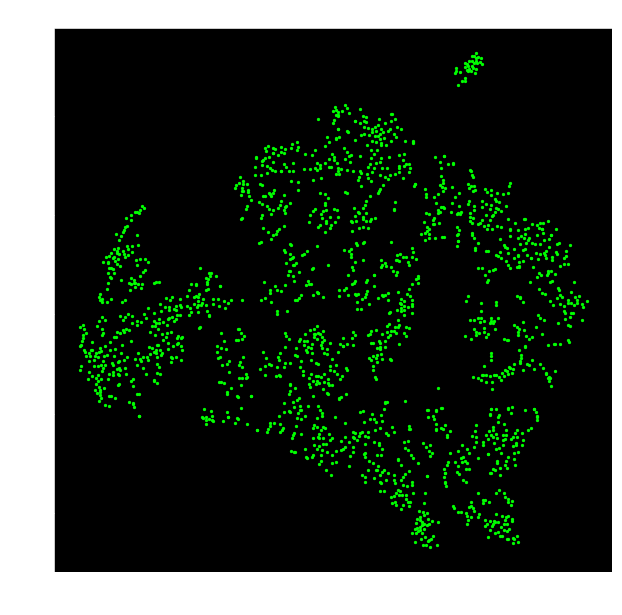

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(x_tsne,y_tsne,s=5,c="#00FF00")
plt.title("TSNE 2 dimensions data map",fontsize=20)
plt.savefig("TSNE2D.png",quality=100)
plt.xlabel("X",fontsize=15)
plt.ylabel("Y",fontsize=15)
plt.show()

### Clustering

Kmeans

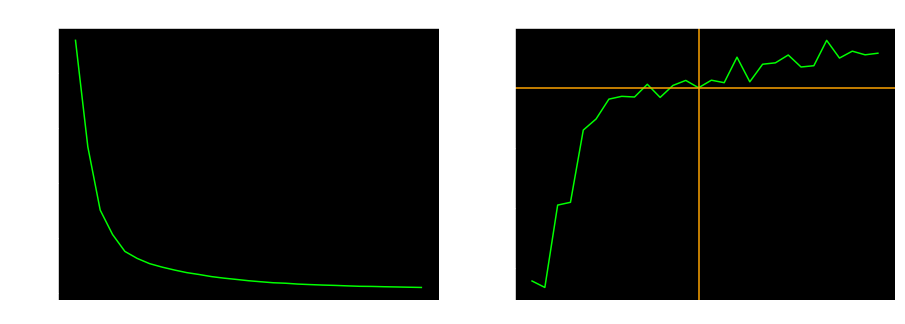

In [15]:
inertiano=[]
inertiaval=[]
inertiachg=[]
for i in range(1,30):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(tsnedata)
    inertiano.append(i)
    inertiaval.append(kmeans.inertia_)
    if i!=1:
        inertiachg.append(inertiaval[i-1]/inertiaval[i-2]-1)
    if i==1:
        inertiachg.append(0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(inertiano,inertiaval,c="#00FF00")
plt.title("Inertia Elbow",fontsize=20)
plt.subplot(122)
plt.plot(inertiano[1:30],inertiachg[1:30],c="#00FF00")
plt.title("Inertia Change %",fontsize=20)
plt.axvline(15,c="orange")
plt.axhline(-0.1,c="orange")
plt.savefig("INERTIA2D.png",quality=100)
plt.show()


In [16]:
kmeansnoclus=15
kmeans = KMeans(n_clusters=kmeansnoclus, random_state=0).fit(tsnedata)

In [17]:
kmeansdata = pd.DataFrame(np.concatenate((tsnedata,np.array(kmeans.labels_).
                                          reshape(-1,1)),axis=1),columns=["x","y","label"])

In [18]:
kmeansdata["permno"]=basedata.index
kmeansdata.set_index("permno",inplace = True)

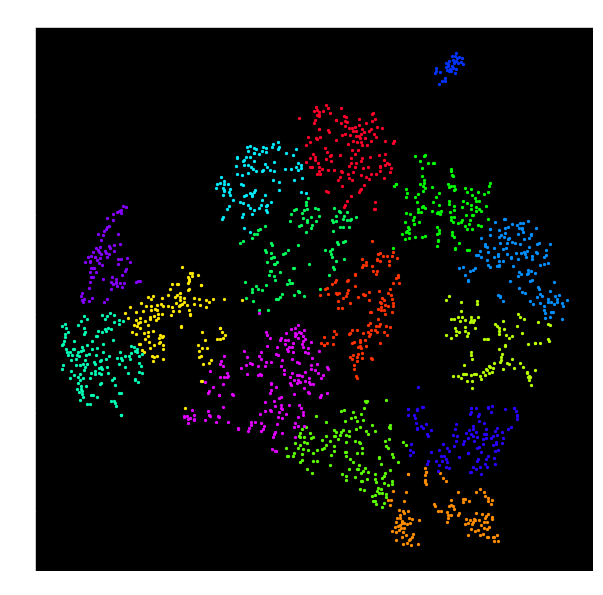

In [19]:
plt.figure(figsize=(10,10))
cmap = matplotlib.cm.get_cmap('gist_rainbow')
for i in range(kmeansnoclus):
    d_temp=kmeansdata[kmeansdata["label"]==i]
    x_temp=d_temp.loc[:,"x"]
    y_temp=d_temp.loc[:,"y"]
    plt.scatter(x_temp,y_temp,s=5,color=cmap(i/kmeansnoclus))
plt.title("K-means clustering - k:"+str(kmeansnoclus),fontsize=20)
plt.savefig("KMEANS2D.png",quality=100)
plt.show()

In [20]:
#kmeansdata.groupby("label").count().to_csv("KMclustering.csv")

### DBScan 

cluster: 90 noise: 599 eps: 1.5 minpts: 5
cluster: 41 noise: 402 eps: 2.5 minpts: 10
cluster: 18 noise: 192 eps: 3.5 minpts: 15
cluster: 13 noise: 62 eps: 4.5 minpts: 20
cluster: 4 noise: 8 eps: 5.5 minpts: 25
cluster: 3 noise: 1 eps: 6.5 minpts: 30


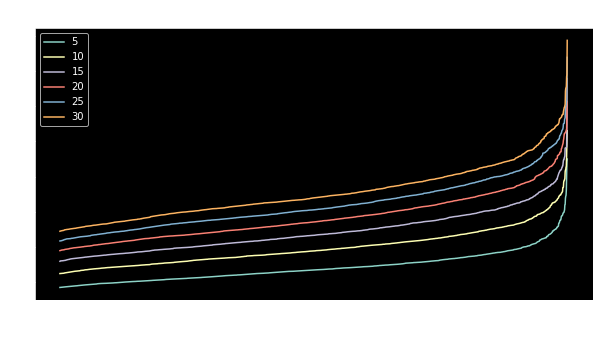

In [21]:
minptslist=[5,10,15,20,25,30]
plt.figure(figsize=(10,5))
for minpts in minptslist:
    neighbourdist = kneighbors_graph(tsnedata, n_neighbors=minpts,mode="distance",
                                     metric="euclidean", n_jobs=-1)
    avgdistlist=[]
    for i in range(neighbourdist.shape[0]):
      avgdist=np.array(-np.sort(-neighbourdist[i].todense()))[0,:minpts].mean()
      avgdistlist.append(avgdist)

    avgdistlist = sorted(avgdistlist)

    plt.plot(range(100,neighbourdist.shape[0]),avgdistlist[100:],label=minpts)
    plt.xlabel("Number of Samples")
    plt.ylabel("Distance")
    plt.title("MinPTS vs Eps",fontsize=20)
    
    epsval=1.5+1*minptslist.index(minpts)
    dbscan = DBSCAN(eps=epsval, min_samples=minpts,metric="euclidean").fit(tsnedata)
    dbscanlabels= len(np.unique(dbscan.labels_))
    dbscannoise=  np.count_nonzero(dbscan.labels_ == -1)
    print ("cluster:",dbscanlabels,"noise:",dbscannoise,"eps:",epsval,"minpts:",minpts)

plt.legend()
plt.savefig("EPSMINPTS2D.png",quality=100)
plt.show()

In [22]:
dbscan = DBSCAN(eps=3.5, min_samples=15).fit(tsnedata)

In [23]:
dbscandata = pd.DataFrame(np.concatenate((tsnedata,np.array(dbscan.labels_).
                                          reshape(-1,1)),axis=1),columns=["x","y","label"])


In [24]:
print("Number of clusters:",len(np.unique(dbscan.labels_)))

Number of clusters: 18


In [25]:
dbscandata.head(3)

,x,y,label
0,-16.046818,-7.790893,5.0
1,-9.120833,20.936216,0.0
2,-6.400083,21.119713,0.0


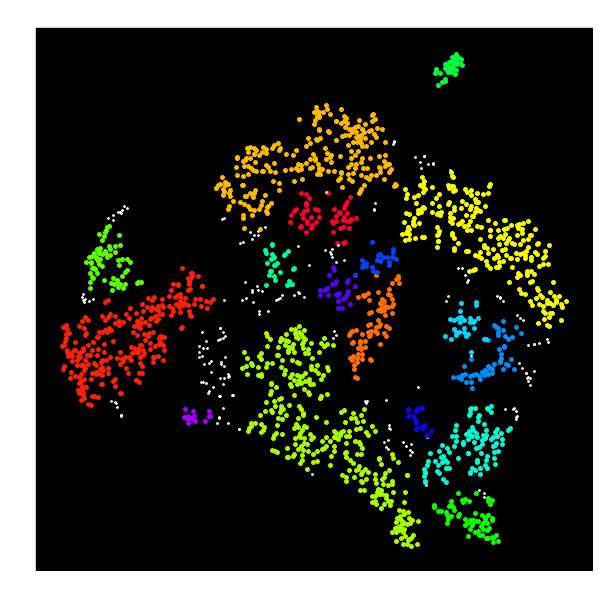

In [26]:
plt.figure(figsize=(10,10))
dbscanclus=list((dbscandata["label"].unique().astype("int")))
cmap = matplotlib.cm.get_cmap('gist_rainbow')
for i in dbscanclus:
    d_temp=dbscandata[dbscandata["label"]==i]
    x_temp=d_temp.loc[:,"x"]
    y_temp=d_temp.loc[:,"y"]
    if i!=-1:
        plt.scatter(x_temp,y_temp,s=15,color=cmap(i/len(dbscanclus)))
    if i==-1:
        plt.scatter(x_temp,y_temp,s=3,c="white")
plt.title("DBScan Clusters before Noise Allocation",fontsize=20)
plt.savefig("DBSCAN2D N.png",quality=100)
plt.show()

Allocate the Noise to Clusters

In [27]:
dbstemp = dbscandata[dbscandata["label"]!=-1]
X = dbstemp[["x","y"]]
y= dbstemp["label"]

In [28]:
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [29]:
dbsnoise=dbscandata[dbscandata["label"]==-1]
Xnoise = dbsnoise[["x","y"]]
ypredict = clf.predict(Xnoise)

In [30]:
count=0
for item in dbsnoise.index:
    dbscandata.loc[item,"label"]=int(ypredict[count])
    count+=1

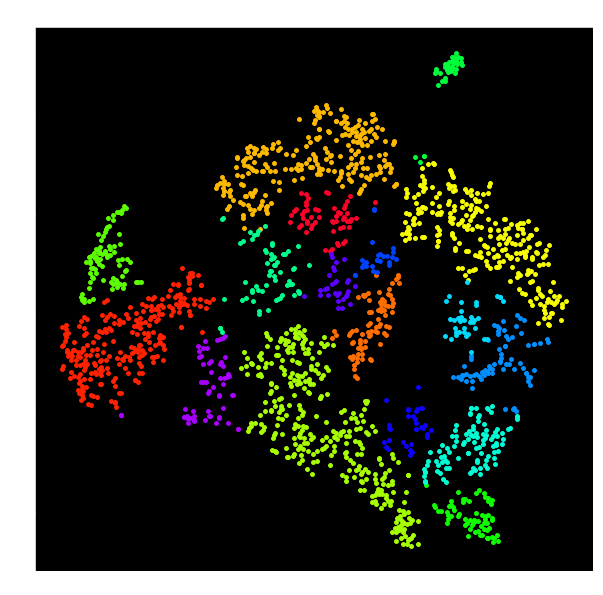

In [31]:
plt.figure(figsize=(10,10))
dbscannoclus=list((dbscandata["label"].unique().astype("int")))
cmap = matplotlib.cm.get_cmap('gist_rainbow')
for i in dbscannoclus:
    d_temp=dbscandata[dbscandata["label"]==i]
    x_temp=d_temp.loc[:,"x"]
    y_temp=d_temp.loc[:,"y"]
    if i!=-1:
        plt.scatter(x_temp,y_temp,s=15,color=cmap(i/len(dbscanclus)))
    if i==-1:
        plt.scatter(x_temp,y_temp,s=4,c="white")
plt.title("DBScan Clustering after Noise Allocation",fontsize=20)
plt.savefig("DBSCAN2D.png",quality=100)
plt.show()

In [32]:
dbscandata[dbscandata["label"]==-1]

,x,y,label


In [33]:
dbscandata["permno"]=basedata.index
dbscandata.set_index("permno",inplace = True)

In [34]:
dbscandata.head()

,x,y,label
permno,,,
10026,-16.046818,-7.790893,5.0
10032,-9.120833,20.936216,0.0
10044,-6.400083,21.119713,0.0
10107,-1.246149,12.136477,15.0
10138,-27.597982,-13.807671,16.0


In [35]:
#dbscandata.groupby("label").count().to_csv("dbsclustering.csv")

### Prediction of Labels for 2018 shares - DBScan

In [36]:
X_base = pd.DataFrame(basedatasc,index=basedata.index)
y_base = dbscandata["label"]
clf_base =RandomForestClassifier(random_state =0,max_depth=50,n_estimators=10)
#clf_base =GradientBoostingClassifier(random_state = 0)
#clf_base = IsolationForest()
clf_base.fit(X_base, y_base)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
preddata = rawdata[rawdata["permno"].isin(sec_testlist)]
preddata = preddata.groupby(["permno"]).mean()
preddata.drop(["qdate","Qyear"],axis=1, inplace = True)
preddata = preddata.fillna(preddata.mean())

In [38]:
preddata.shape

(140, 68)

In [39]:
preddatasc = scaler.transform(preddata)
y_predict = (clf_base.predict(preddatasc))
y_preddf=pd.DataFrame(index=preddata.index)
y_preddf["pred"]=y_predict

### Prediction of Labels for 2018 shares - Kmeans

In [40]:
X_basekm = pd.DataFrame(basedatasc,index=basedata.index)
y_basekm = kmeansdata["label"]
clf_basekm =RandomForestClassifier(random_state =0,max_depth=50,n_estimators=10)
#clf_basekm =GradientBoostingClassifier(random_state = 0)
#clf_basekm = IsolationForest()
clf_basekm.fit(X_basekm, y_basekm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [41]:
preddatakm = rawdata[rawdata["permno"].isin(sec_testlist)]
preddatakm = preddatakm.groupby(["permno"]).mean()
preddatakm.drop(["qdate","Qyear"],axis=1, inplace = True)
preddatakm = preddatakm.fillna(preddatakm.mean())

In [42]:
preddatasckm = scaler.transform(preddatakm)
y_predictkm = (clf_basekm.predict(preddatasckm))
y_preddfkm=pd.DataFrame(index=preddatakm.index)
y_preddfkm["pred"]=y_predictkm

### Security Prices

In [43]:
pricedataraw = pd.read_csv("prices2.csv")
pricedata = pricedataraw.join(pricedataraw["date"].str.split(pat="/",expand=True))
pricedata.columns=(["permno","date","prc","day","month","year"])
pricedata["prc"]=pricedata["prc"].fillna(value=0)
seclist = pricedata["permno"].unique()

In [44]:
pricedata = (pricedata.groupby(["year","permno"]).mean())
pricedata = pricedata.reset_index()
pricedata17 = pricedata[pricedata["year"]=="2017"]
pricedata18 = pricedata[pricedata["year"]=="2018"]
pricedata17.set_index("permno",inplace=True)
pricedata18.set_index("permno",inplace=True)

DBScan

In [45]:
y_preddf2 = y_preddf.join(pricedata17["prc"])
y_preddf2.columns=["cluster","2017avg"]
y_preddf2 = y_preddf2.join(pricedata18["prc"])
y_preddf2.columns=["cluster","2017avg","2018avg"]
y_preddf2 = y_preddf2[y_preddf2["2018avg"].notna()]
y_preddf2 = y_preddf2[y_preddf2["2017avg"].notna()]

In [46]:
clusters = pd.DataFrame(index=dbscandata.index)
clusters["cluster"]=dbscandata["label"]
clusterreturns = clusters.join(pricedata17["prc"])
clusterreturns.columns=["cluster","2017avg"]
clusterreturns = clusterreturns.join(pricedata18["prc"])
clusterreturns.columns=["cluster","2017avgC","2018avgC"]
clusterreturnssum = clusterreturns.groupby("cluster").mean()

In [47]:
y_preddffinal = y_preddf2.join(clusterreturnssum,on="cluster")

In [48]:
y_preddffinal["secreturn"]=y_preddffinal["2018avg"]/y_preddffinal["2017avg"]-1
y_preddffinal["clusreturn"]=y_preddffinal["2018avgC"]/y_preddffinal["2017avgC"]-1
y_preddffinal["nasdaqreturn"]=7425.98/6235.29-1
y_preddffinal["clusdif"]=abs(y_preddffinal["secreturn"]-y_preddffinal["clusreturn"])
y_preddffinal["indexdif"]=abs(y_preddffinal["secreturn"]-y_preddffinal["nasdaqreturn"])
print("Difference with CLusters",y_preddffinal["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinal["indexdif"].mean())
print("Improvement",-(y_preddffinal["clusdif"].mean()/y_preddffinal["indexdif"].mean()-1))

Difference with CLusters 0.31300335559467923
Difference with Nasdaq Index 0.3443057835384096
Improvement 0.09091461555492109


In [49]:
y_preddffinal["clusdif"]=(y_preddffinal["secreturn"]-y_preddffinal["clusreturn"])
y_preddffinal["indexdif"]=(y_preddffinal["secreturn"]-y_preddffinal["nasdaqreturn"])
print("Difference with CLusters",y_preddffinal["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinal["indexdif"].mean())
print("Improvement",-(y_preddffinal["clusdif"].mean()/y_preddffinal["indexdif"].mean()-1))


Difference with CLusters -0.10167666068181896
Difference with Nasdaq Index -0.16105461672843224
Improvement 0.3686821107819309


In [50]:
#y_preddffinal.groupby("cluster").count().to_csv("DBSpredictiondist.csv")

Kmeans

In [51]:
y_preddf2km = y_preddfkm.join(pricedata17["prc"])
y_preddf2km.columns=["cluster","2017avg"]
y_preddf2km = y_preddf2km.join(pricedata18["prc"])
y_preddf2km.columns=["cluster","2017avg","2018avg"]
y_preddf2km = y_preddf2km[y_preddf2km["2018avg"].notna()]
y_preddf2km = y_preddf2km[y_preddf2km["2017avg"].notna()]

In [52]:
clusterskm = pd.DataFrame(index=kmeansdata.index)
clusterskm["cluster"]=kmeansdata["label"]
clusterreturnskm = clusterskm.join(pricedata17["prc"])
clusterreturnskm.columns=["cluster","2017avg"]
clusterreturnskm = clusterreturnskm.join(pricedata18["prc"])
clusterreturnskm.columns=["cluster","2017avgC","2018avgC"]
clusterreturnskmsum = clusterreturnskm.groupby("cluster").mean()

In [53]:
y_preddffinalkm = y_preddf2km.join(clusterreturnskmsum,on="cluster")

In [54]:
y_preddffinalkm["secreturn"]=y_preddffinalkm["2018avg"]/y_preddffinalkm["2017avg"]-1
y_preddffinalkm["clusreturn"]=y_preddffinalkm["2018avgC"]/y_preddffinalkm["2017avgC"]-1
y_preddffinalkm["nasdaqreturn"]=7425.98/6235.29-1
y_preddffinalkm["clusdif"]=abs(y_preddffinalkm["secreturn"]-y_preddffinalkm["clusreturn"])
y_preddffinalkm["indexdif"]=abs(y_preddffinalkm["secreturn"]-y_preddffinalkm["nasdaqreturn"])
print("Difference with CLusters",y_preddffinalkm["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinalkm["indexdif"].mean())
print("Improvement",-(y_preddffinalkm["clusdif"].mean()/y_preddffinalkm["indexdif"].mean()-1))

Difference with CLusters 0.33483241369021655
Difference with Nasdaq Index 0.3443057835384096
Improvement 0.027514408125346668


In [55]:
y_preddffinalkm["clusdif"]=(y_preddffinalkm["secreturn"]-y_preddffinalkm["clusreturn"])
y_preddffinalkm["indexdif"]=(y_preddffinalkm["secreturn"]-y_preddffinalkm["nasdaqreturn"])
print("Difference with CLusters",y_preddffinalkm["clusdif"].mean())
print("Difference with Nasdaq Index",y_preddffinalkm["indexdif"].mean())
print("Improvement",-(y_preddffinalkm["clusdif"].mean()/y_preddffinalkm["indexdif"].mean()-1))

Difference with CLusters -0.13439477462398822
Difference with Nasdaq Index -0.16105461672843224
Improvement 0.1655329269411595


In [56]:
#y_preddffinalkm.groupby("cluster").count().to_csv("KMpredictiondist.csv")

### Recommendation

In [57]:
cossim= pd.DataFrame(cosine_similarity(basedata),index=basedata.index,columns=basedata.index)
for rw in cossim.index:
    cossim.loc[rw,rw]=0

In [58]:
recomdf=pd.DataFrame(index=cossim.index,columns=["recomno","sim","cl1","cl2"])

for row in cossim.index:
    check=0
    while check==0:
        maxval = cossim.loc[row,:].max()
        
        rowserie = cossim.loc[row,:]
        col= rowserie[rowserie==maxval].index[0]
        if dbscandata.loc[row,"label"]!=dbscandata.loc[col,"label"]:
            recomdf.loc[row,"recomno"]=int(col)
            recomdf.loc[row,"sim"]=float(cossim.loc[row,col])
            recomdf.loc[row,"cl1"]=dbscandata.loc[row,"label"]
            recomdf.loc[row,"cl2"]=dbscandata.loc[col,"label"]
            check=1
        else:
            cossim.loc[row,col]=0
            check=0

recomdf["recomno"]=recomdf["recomno"].astype(int)

In [59]:
recommendation = recomdf.join(compdesc,on="recomno")
recommendation.columns=["recom.share.no","similarity","cluster1","cluster2","recommended com."]
recommendation = recommendation.join(compdesc)
recommendation.columns=["recom.share.no","similarity","cluster1","cluster2",
                        "recommended com.","current com."]
recommendation = recommendation[["current com.","recom.share.no","recommended com.","similarity",
                                "cluster1","cluster2"]]

In [60]:
recommendation.head(10)

,current com.,recom.share.no,recommended com.,similarity,cluster1,cluster2
permno,,,,,,
10026,J & J SNACK FOODS CORP,13046,UBIQUITI NETWORKS INC,0.995385,5,4
10032,PLEXUS CORP,80274,SIGMATRON INTERNATIONAL INC,0.982174,0,3
10044,ROCKY MOUNTAIN CHOC FAC INC NEW,17137,BASSETT FURNITURE INDUSTRIES INC,0.987678,0,3
10107,MICROSOFT CORP,88167,HEALTHSTREAM INC,0.942145,15,5
10138,T ROWE PRICE GROUP INC,75517,MARTEN TRANSPORT LTD,0.996502,16,2
10180,AKORN INC,60986,NEWELL BRANDS INC,0.986527,8,3
10182,TECH DATA CORP,75985,HALLMARK FINANCIAL SERVICES INC,0.875151,5,1
10200,REPLIGEN CORP,89110,OMNICELL INC,0.989647,16,9
10232,ELMIRA SAVINGS BANK NY,87269,CITIZENS HOLDING CO,1,1,6


In [61]:
#recommendation.head(10).to_csv("cosinesimilarity.csv")